<h4> Importing Libraries </h4>

In [1]:
import sys
import os 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

sys.path.insert(0, os.path.dirname(os.getcwd()))

from processing.arm_simulations import (
    generate_bernouilli_variables,
    generate_bernoulli_simulation,
)

from modeling.explore_then_commit import explore_then_commit
from modeling.upper_confidence_bound import UCB_sub_gaussian
from modeling.thompson_sampling import thompson_sampling

from processing.analyze_model_performances import (
    plot_upper_confidence_bounds_decrease,
    plot_arm_selection_histogram,
    compute_immediate_regrets,
    compute_strategy_regret,
    compute_instance_worst_possible_regret,
    plot_immediate_regrets,
    plot_regret_versus_UCB_probability_error,
)

from processing.concentration import plot_concentration_inequalities_bounds

<h1> Comparing Concentration Inequalities </h1>

In the slides we've used sub-gaussian rewards and the Chernoff Concentration Inequality to reinforce the intuition behind the strength of confidence intervals. However, you will also find in the litterature the common use of the Hoeffding Inequality (for variables with values bounded between 0 and 1)

$\forall \epsilon \geq 0 . P(|\hat{\mu} - \mu | \geq \epsilon ) \leq e^{-2N\epsilon^2}$

In [2]:
std_values = [0.1, 0.5, 1, 10]

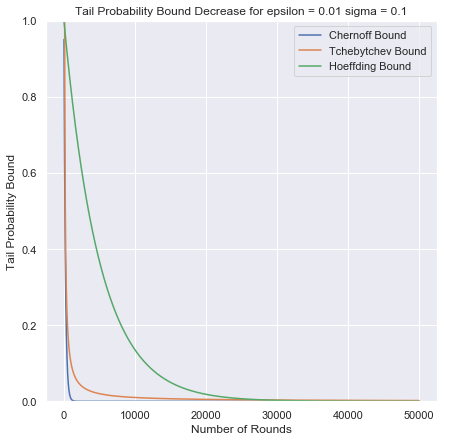

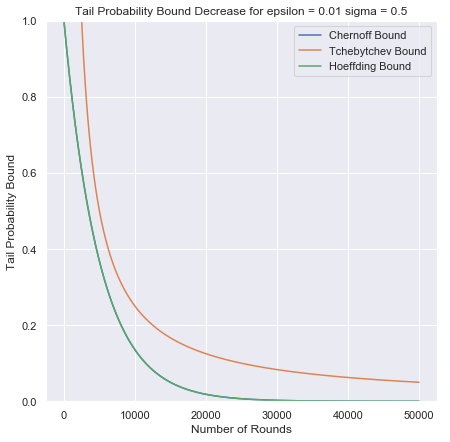

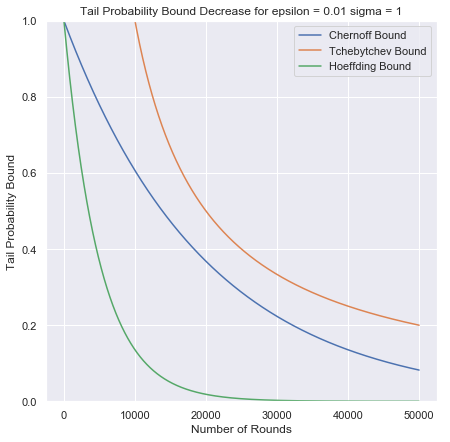

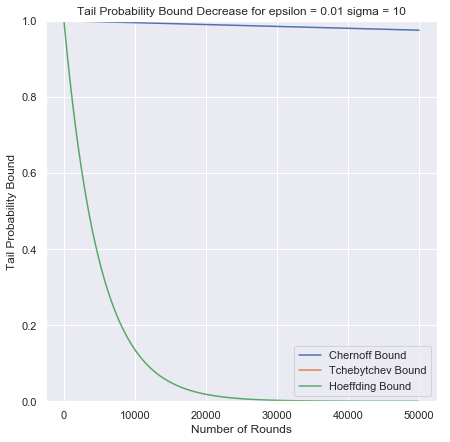

In [3]:
for sigma in std_values:
    plot_concentration_inequalities_bounds(number_rounds = 50000, sigma = sigma, epsilon = 0.01,
                                               figsize = (7,7))

<h1> Plotting Beta Distribution </h1>

In [4]:
from scipy.stats import beta

In [5]:
parameters_configurations = [
    (100,2), (100,6), (100,8), (100,21),(100,51), (100,101)
]

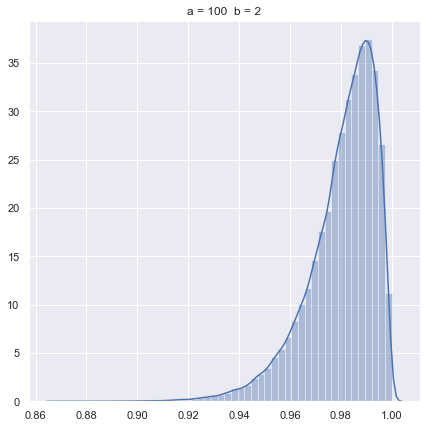

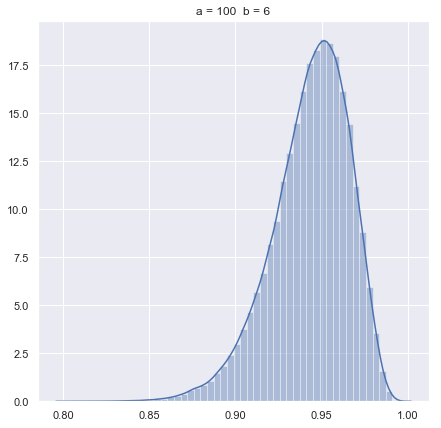

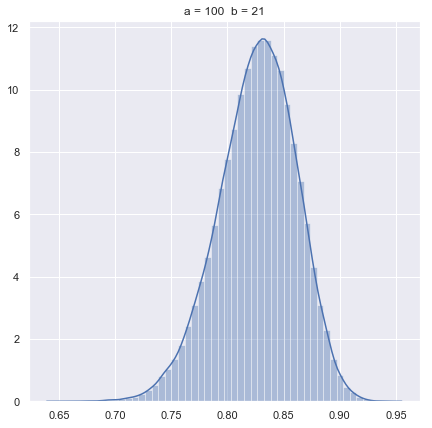

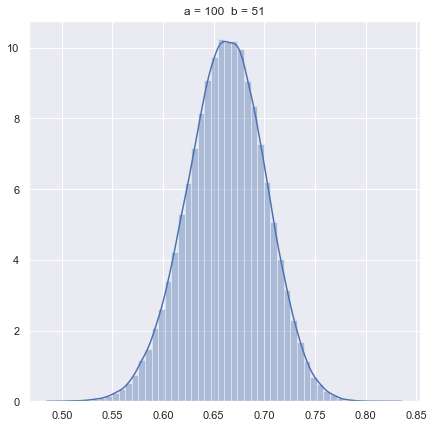

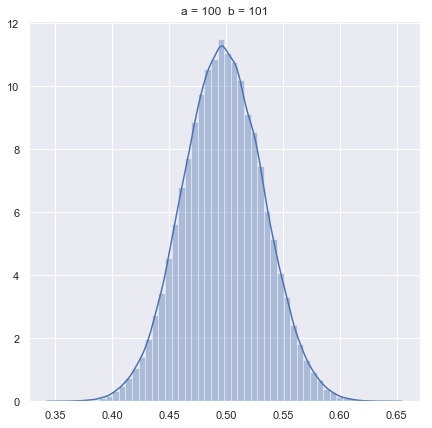

In [6]:
for (a,b) in parameters_configurations:
    beta_distribution = beta.rvs(a= a, b = b, size=100000)
    plt.figure(figsize=(7,7))
    sns.distplot(beta_distribution).set_title("a = " + str(a) + "  b = " + str(b))

<h1> Use Case : Deploying Ads  </h1> 

<h3> Context </h3>

Every B2C Company needs to roll out ads to sell it's newest features to their potential clients. 

Much effort goes into designing advertising campaigns and their posts, but we can never know before starting the campaign what is the best way to sell our brand to our potential clients. This is why most of the time many versions of the same ad are designed, then put in competition against each other during the campaign before the best strategy stabilizes.

<b> Example </b>

<img src="files/Corcoran-A-1.jpg">

For reasons that can be explained (or not) with statistical modeling, on of the ads may be consistently better than the other. As a result, we need a quantitative method to track which ad brings more value as the advertising campaign is happening. This is clearly a Multi-Armed-Bandit Problem.

<h3> The Data </h3>

For the sake of simplicity, we will working with simulated data. The dataset has $N$ rows which will be the rounds given to our different solutions to guess which ad is the best. It will have $K$ columns where each column represents an arm (or ad).

Each observation of the dataset represents the vector of rewards, each component representing the reward that would be observed when playing the corresponding arm.

The reward here represents whether a person has clicked or not on the ad as it was presented to him : it's a Bernoulli experience

The average reward of each arm in this context is called the Click-Through-Rate (CTR), it's probably the most famous KPI in the advertising industry.

The <b><i> generate_bernoulli_simulation </i></b> function generates the dateset by giving it as an input the number of rounds and the click-through rates. You can force specific values of click-through-rates if you want, or use the <b> <i> generate_bernouilli_variables </i> </b> function to generate it for you

<h3> Notebook Objectives </h3>

This notebook will be comparing 4 strategies to adress the advertising use case, 3 of the 4 strategies are already coded.

Each of the section has a goal :
* <b> Section 1 </b> : Comparing Regret Upper Bounds (5-10 minutes)
* <b> Section 2 : </b> Coding a very famous Multi-Armed-Bandit Algorithm (15-20 minutes)
* <b> Section 3 : </b> Interesting hyperparameter configurations for UCB (15-20 minutes)
* <b> Section 4 : </b> Outperforming the UCB with Thompson Sampling (15-20 minutes)


All of the 4 MAB Algorithms get the same kind of inputs and return the same kind of outputs 

<b> Inputs </b> : 
* Simulated Bernoulli rewards dataset
* Hyperparameter of the algorithm 

<b> Outputs : </b>
* The rewards for each arm (list of lists)
* The list of selected arms for each round

<h1> Strategy 1 : Explore then Commit - AB Testing  </h1>

AB Testing is the most commonly used statistical method by websites or advertising teams whenever they want to roll out feature and test it's efficiency using many different versions of the feature.

In AB Testing, we usually start with a Control Group (for example, an older version of the ad) and a Test Group (the latest version of the ad). Then, we give ourselves a certain number of trial rounds. During these trial rounds, we choose each group the same number of times.

This is equivalent to a <b> 2-Armed-Bandit </b> setting with a strategy called <b> Uniform Exploration </b> or <b> Explore then Commit (ETC) </b>: explore arms uniformly for $M$ rounds each, regardless of what has been observed previously ($2M$ rounds total for exploration), then pick the empirically best arm for exploitation during the $N - 2M$ left rounds.

In [7]:
number_of_rounds = 40000

We will be simulating the Bernoulli experiments to generate the data for this study :
* Ad A Conversion Rate : 0.15
* Ad B Conversion Rate : 0.22

In [8]:
ads_click_through_rates = [0.15, 0.22]

In [9]:
dataset = generate_bernoulli_simulation(number_of_rounds, ads_click_through_rates)

<h3> Running the AB Test </h3>

In [10]:
rewards_per_arm, selected_arms = explore_then_commit(dataset.values, number_exploration_rounds= 1000)

<h3> Comparing Regret Upper Bound </h3>

We can run the code as many times as we like, but once thing is certain, if we prove an upper bound on the expected regret, it guarantees a correctly implemented strategy never diverges  

For each arm $a$ we use as a value $r(a) = \sqrt\frac{2log(N)}{M}$ which gives us, by using Hoeffding's Inequality, the following concentration inequality :

$P(|\hat{\mu} - \mu | \geq r(a) ) \leq \frac{1}{N^4}  \Rightarrow  P(|\hat{\mu} - \mu | \leq r(a) ) \geq 1 - \frac{1}{N^4} \geq 1 - \frac{2}{N^4}$ 

Just like in UCB's Regret Analysis in the slides, we can define a "clean" event and a bad event and study the regret separately for each. The maths behind the regret analysis can be found at the end of the notebook as an annex.

We will give the upper bound directly : $E(R(N)) \leq M K + O(N\sqrt\frac{log(N)}{M})$

<b> Question 1 : </b> What phenomenon does each of the two terms in the upper bound represent ? <b> (2 mins) </b>

<b> Answer :</b> The first term represents the <b> exploration </b> phase's contribution to the regret while the second term represents <b> exploitation </b> : Keeping $M$ small makes the second term high, this makes senses since spending little time exploring increases our chances of commiting to the wrong arm. On the other hand, increasing $M$ decreases that risk, but increases the first term's contribution to the regret : <b> it's the exploration-exploitation tradeoff </b> 

We set $M$ so that the two terms are (approximately) equal. For $M = (\frac{N}{K})^{\frac{2}{3}}(log (N))^{\frac{1}{3}}$ , we obtain : <b> $ E(R(N)) \leq N^{\frac{2}{3}}O(Klog(N))^{\frac{1}{3}}$ </b>

<b> Question 2 : </b> For $K=2$ Compare this upper bound with UCB's upper bound by plotting them for a range of values of $N$ (UCB's upper bound can be found in slide 38, start by taking $t=N$ <b> (5 mins)</b>

<b> Answer </b>

In [11]:
def etc_bound(N, K):
    res = K*np.log(N)
    res = res**(1/3)
    res = res*(N**(2/3))
    return res

In [12]:
def ucb_bound(N, K, t):
    res = t*K*np.log(N)
    res = np.sqrt(res)
    return res

In [13]:
etc_data = [etc_bound(N,2) for N in range(2, 100000)] 
ucb_data = [ucb_bound(N,2, N) for N in range(2, 100000)]

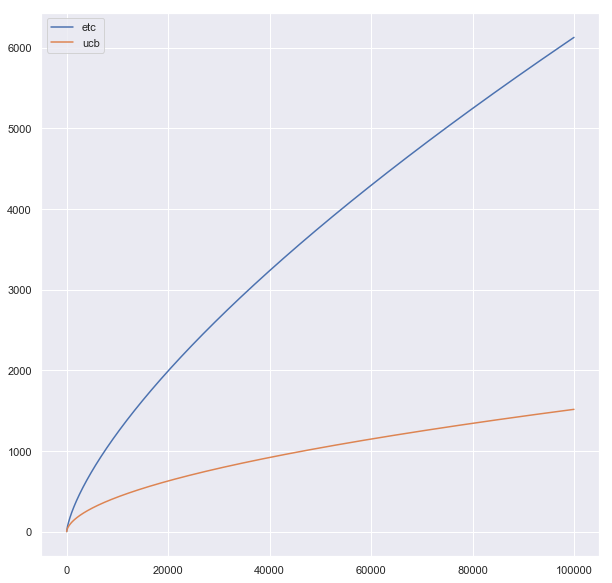

In [14]:
sns.set()
plt.figure(figsize=(10,10))
plt.plot(etc_data, label = "etc")
plt.plot(ucb_data, label = "ucb")
plt.legend()

Even when taking $t=N$ (worst UCB upper bound) we can still acheive with <b> much more interesting performance guarantees than ETC. The risk of AB-Testing is uselessly high </b>

<h3> Main limitation of an AB Test <h3>

<b> Limitation 1 : We can't know which ad is best during the AB Testing Campaign </b> 

All our results rely on the assumption that we need as many observations in the Test Group as in the Control Group, which requires us to deploy both ads to real users a sufficient number of times just to decide which one should be kept as the final ad to use.

And we need to do this each time we have a new feature/ad to roll out.

In a nutshell, <b> we can't identify which ad is the best until we have wasted a signigicant amount of impressions </b> 

For websites with a lot of traffic, this may not be a problem, but a start up with a limited amount of funds to buy impressions on the web can't afford to allocate enough ressources for this kind of testing

<b> We need to be able to learn on the fly which ad is the best to deploy </b>

<b> Limitation 2 : What if we need to test many new features at once ? </b>

We may also not have the time or ressources to do an AB Test for every important feature we need to roll out, and if we want to roll out many features at once, it would be even more ressource-intensive define many test groups and track the added value simultaneously

In the example below, we would like to quickly identify in a statisticaly significant manner which ad is the best, the AB test is not a convenient enough solution

<img src="files/null-6.png">

<h1> Strategy 2 : $\epsilon$-greedy </h1>

A clear take-away from Strategy 1 is that exploration should not be concentrated at the beginining, it should be spread out over the $N$ rounds. This can also allow us to potentially suffer less regret if we choose the sub-optimal arm less often.

From now on, we can also choose to work with $K \geq 2$

<h3> Main Idea </h3>

A simple and very famous strategy that spreads out exploration is called $\epsilon$-greedy and works like the following : 

During all $N$ rounds :
* <b> With probability $\epsilon$ </b>: Choose the empirically best arm available
* <b> With probability $1 - \epsilon$ </b>: Choose any other arm but the empirically best one (forced exploration)

<b> Question 4: </b> Should $\epsilon$ stay constant or should it vary during execution ? In case it's the second choice, how should it vary ? <b>(2 mins) </b>

<b> Answer : </b>  Since at first you have little information about the arms, the concept of an "empirically best arm" doesn't make much sense, it is best to start with a low  value of $\epsilon$ to gather information and increase it as the algorithm learns. 

<h3> Coding $\epsilon$-greedy </h3>

During each round of $\epsilon$-greedy there always two steps happening :
* Identifying which arm is the best
* Use epsilon to decide if you will use the identified best arm or not

The two following functions correspond to the two main steps of each round, they are both used in the global function epsilon_greedy that runs the whole strategy 

<b> Question 4: </b> Complete the <b> <i> identify_current_best_arm </i> </b> function and the <b> <i> select_arm_with_epsilon_greedy_strategy </i> </b> function then run the global <b> <i> epsilon_greedy </i> </b> function <b> (5-10 mins) </b>

In [ ]:
def identify_current_best_arm(rewards_per_arm):
    
    ######### Your code goes here !
    return current_best_arm

In [ ]:
def select_arm_with_epsilon_greedy_strategy(number_of_arms, epsilon, current_best_arm):

    ######### Your code goes here ! 
    return selected_arm

In [ ]:
def epsilon_greedy(dataset, epsilon):

    number_of_rounds = dataset.shape[0]
    number_of_arms = dataset.shape[1]
    rewards_per_arm = {arm: [] for arm in range(number_of_arms)}
    selected_arms = []

    for episode in range(number_of_rounds):
        if episode < number_of_arms:
            ### Initialization : We have to play each arm at least once before the strategy can be implemented
            selected_arm = episode
        else:
            current_best_arm = identify_current_best_arm(rewards_per_arm)
            selected_arm = select_arm_with_epsilon_greedy_strategy(
                number_of_arms, epsilon, current_best_arm
            )

        selected_arms.append(selected_arm)
        rewards_per_arm[selected_arm].append(dataset[episode][selected_arm])

    return rewards_per_arm, selected_arms


<b> Answer : </b> The full code is in the following script

In [15]:
from modeling.epsilon_greedy import epsilon_greedy

<h3> Running $\epsilon$-greedy </h3>

In [20]:
number_of_rounds = 10000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [21]:
dataset = generate_bernoulli_simulation(number_of_rounds, click_through_rates)

In [22]:
rewards_per_arm, selected_arms = epsilon_greedy(dataset.values, epsilon = 0.5)

100%|██████████| 10000/10000 [00:03<00:00, 2617.64it/s]


<b> Question 5: </b> What do you think is the main limitation behind $\epsilon$-greedy's method of exploring sub-optimal arms ? ( the <i> <b> plot_arm_selection_histogram </b> </i> function can help you find the answer) <b> (2-5 mins) </b>

In [23]:
plot_arm_selection_histogram(selected_arms)

<b> Answer : </b> When $\epsilon$-greedy chooses not to use the empirically best arm, it randomly selects all other arms with a uniform probability. This means that <b> all sub-optimal arms are considered equally even if some may be more advantageous than others. </b> As a result $\epsilon$-greedy's method of exploration is too naive and can clearly be optimized by creating a ranking between sub-optimal arms which UCB undirectly does.

<b> $\epsilon$-greedy's Expected Regret : </b> For all rounds $i$  :  <b> $ E(R(N)) \leq i^{\frac{2}{3}}O(Klog(i))^{\frac{1}{3}}$ </b> (Better than Uniform Exploration since we move from an $N$ dependence to an $i$ dependence, but still less good than UCB which explored in a smarter way)

<h1> Strategy 3 : Adaptive Exploration using the UCB algorithm </h1>

The UCB Algorithm for sub-gaussian rewards has already been coded ! The objective here is to study the impact of different hyperparameters on the regret when we run UCB :

<h3> Running the UCB </h3>

In [29]:
number_of_rounds = 7000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [30]:
click_through_rates

array([0.21152468, 0.01744033, 0.20351844, 0.56751655])

In [31]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [32]:
probability_error = 0.05
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, probability_error)

The function <b> <i> plot_upper_confidence_bounds_decrease </i> </b>  plots for each arm the decrease of the UCB value as the algorithm converges 

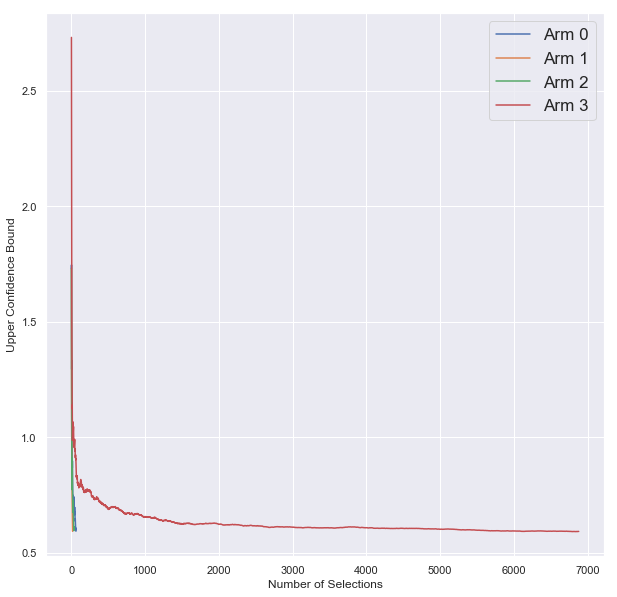

In [33]:
####### Don't use this function for very high values of K 
plot_upper_confidence_bounds_decrease(upper_confidence_bounds, figsize = (10, 10))

<b> Question 6: </b> Why do the UCB curves stop and only one continues ? <b> (2 mins) </b>

<b> Answer : </b> Because at some point the algorithm stops gathering data about suboptimal arms since it identified the empiricaly best arm.

<h3> Regret vs Probability Error $\delta$ </h3>

In [39]:
number_of_rounds = 10000
number_of_arms = 4
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [41]:
forced_click_through_rates = [0.1, 0.7, 0.2, 0.05]

In [42]:
dataset = generate_bernoulli_simulation(number_of_rounds, forced_click_through_rates)

The <b> <i> plot_regret_versus_UCB_probability_error </i> </b> takes, in addition to UCB's inputs, a list of $\delta$ values, it runs UCB for each value of $\delta$ then computes the regret, then it plots all the calculated regrets after running UCBs vs $\delta$ 

In [43]:
probability_errors = np.linspace(0.3, 0.9, 25)

<b> Question 6: </b> Force the click-through-rate values to be very far apart then run the UCB, why does choosing a higher value of $\delta$ decrease the regret ? <b> (10 mins) </b>

If the function runs for too long, reduce the number of rounds when generating the dataset or reduce the number of probability errors you test

100%|██████████| 25/25 [01:17<00:00,  3.11s/it]


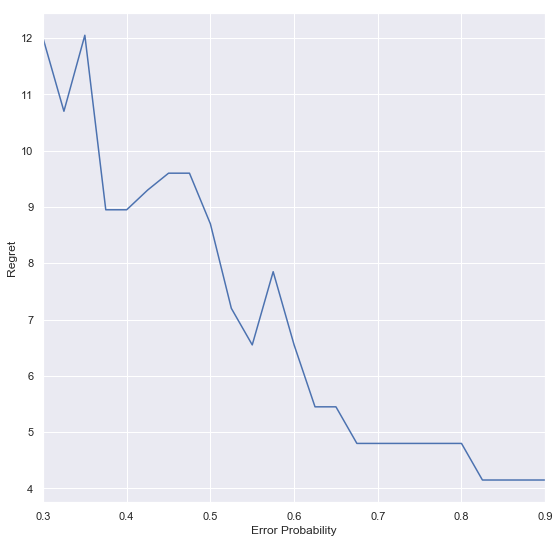

In [44]:
plot_regret_versus_UCB_probability_error(
    dataset, forced_click_through_rates, probability_errors
)

<b> Answer : </b> The goal the UCB algorithm is to converge towards the real value of the CTR by building a confidence interval around it. This can only work if the confidence interval conntains the mean we are trying to converge towards. Our hyperparameter $\delta$'s goal is to quantify the probability of our confidence interval missing the mean. Low values of $\delta$ means we take extra-caution by increasing the size of the interval and make it decrease slowly. This also helps us making sure that we converge towards the right arm if their means are very close. <b> This extra effort is not useful if the arms are very easy to differentiate. </b> By having a high value of $\delta$ we explore much less because the intervals decrease much faster because we care less about containing the mean. And this works in a setting where <b> careful exploration is not needed to find the best arm, since this best arm far outclasses all the others </b>

<h3> UCB Weakness : High number of arms </h3>

We will be dealing with of the limitations of UCB : when the number of arms becomes too high.

Given a Bernoulli data simulation, the worst possible strategy is to constantly choose the worst arm (which means the arm with the lowest average reward). The regret of this strategy constitues an upper bound for the data simulation (and this upper bound cannot be higher than the theoretical upper bound we have proven in the course)

The following function <b> <i> compute_instance_worst_possible_regret </i> </b> calculates the regret associated to the worst possible strategy given a Bernoulli data simulation

In [ ]:
compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))

While the <b> <i> compute_strategy_regret </i> </b> function calculated the regret of the algorithm that ran with the imput Bernoulli data simulation

In [ ]:
compute_strategy_regret(number_of_rounds, "Strategy Selected Arms goes here !!!!", click_through_rates)

<b> Question 7 : </b> Compute the UCB's regret in an instance with a high number of arms $K$ and compare it to the worst case regret. Why does UCB acheive such low performance when K increases ? (The <b> <i> plot_arm_selection_histogram </i> </b> may help you understand why) <b> (10 mins) </b>

In [45]:
number_of_rounds = 10000
number_of_arms = 100
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [46]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [47]:
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, 0.05)

In [48]:
ucb_regret = compute_strategy_regret(number_of_rounds, ucb_selected_arms, click_through_rates)
ucb_regret

815.3965327600298

In [49]:
instance_worst_regret = compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))
instance_worst_regret

926.738113289704

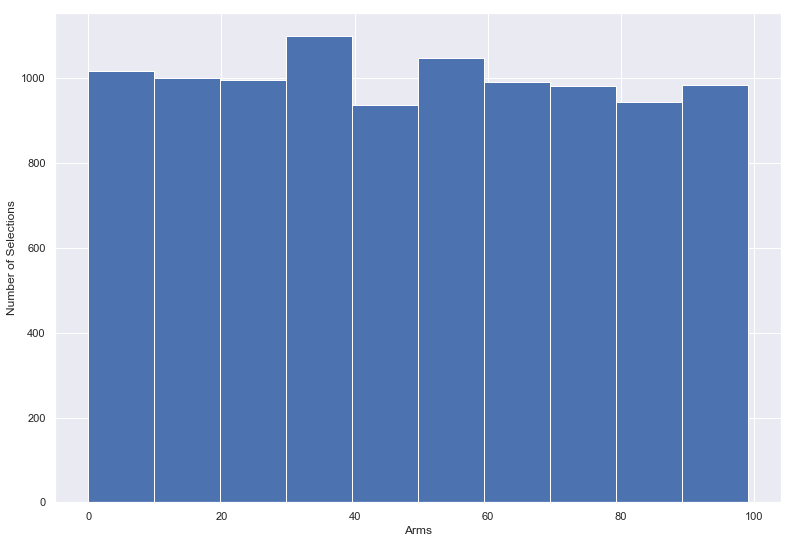

In [50]:
plot_arm_selection_histogram(ucb_selected_arms)

<b> Answer : </b> UCB works with the concept of optimism in the face of uncertainty. This is nice because it forces the algorithm to explore any arm with few information, but it will also <b> cause the algorithm to be optimistic about arms with a terrible average reward </b>. It will explore such arms less than others, but if you multiply the number of arms, <b> it will have to give them all a try no matter what, which means we need a lot of samples just to gather minimal information about each arm </b> (Running the algorithm with $N = 10 000$ and $K = 100$ barely makes the algorithm start to distinguish the good arms from the bad ones.

<h1> Strategy 4 : Adaptive Exploration using Thompson Sampling </h1>

<h3> Thompson Sampling Strategy </h3>

Computing the regret of an instance is good, but since by definition it is a sum, it doesn't tell us about how the regret evolved during the Algorithm's learning process. This is why we are also interessted in <b> immediate regret </b> which is the regret you get at <b>each round </b> while running the algorithm

The <b> <i> compute_immediate_regrets </i> </b> function calculates the immediate regret of each round that the algorithm went through during the learning process.

The <b> <i> plot_immediate_regrets </i> </b> function allows us to plot the evolution of immediate regret and assess if an algorithm is really converging towards small regrets (ideally close to 0) or not. 

In [51]:
number_of_rounds = 7000
number_of_arms = 15
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [52]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [53]:
thompson_rewards, thompson_selected_arms = thompson_sampling(dataset.values, click_through_rates)

In [54]:
thompson_regret = compute_strategy_regret(number_of_rounds, thompson_selected_arms, click_through_rates)

In [55]:
thompson_immediate_regrets = compute_immediate_regrets(thompson_rewards, max(click_through_rates))

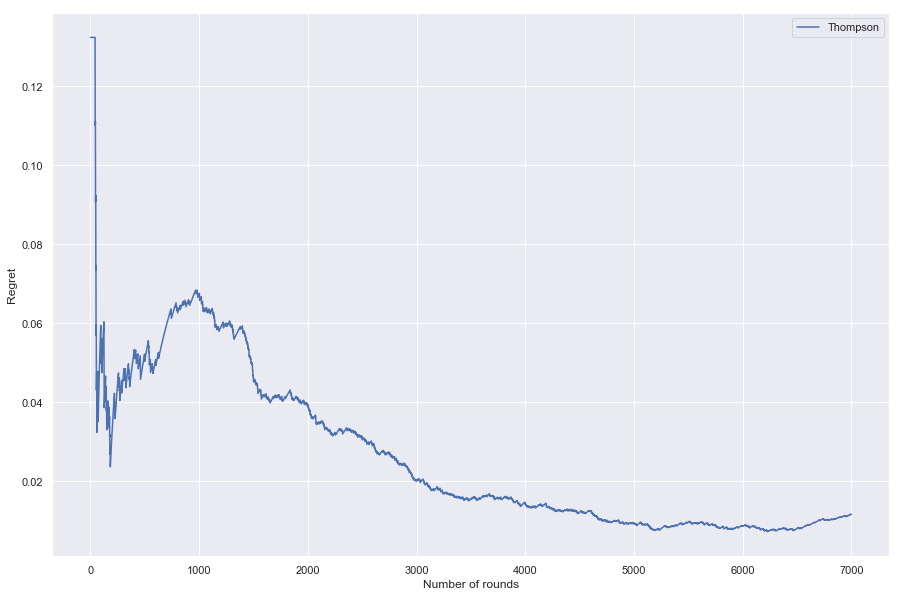

In [56]:
plot_immediate_regrets([thompson_immediate_regrets],
                       labels = ['Thompson'])

<b> Question 8:</b> Why is Thompson Sampling's regret so random at first ? <b> (2 mins) </b>

<b> Answer : </b> As a Bayesian algorithm, initializing the priors of the Beta distribution is very important. Assuming we have no knowledge about the arms, choosing a uniform distribution of prior probabilities seems natural. But because this doesn't represent reality, performance will fluctuate a lot at the beginning since we are giving more probabilities to sub-optimal arms than they should. This is aspecially true if the gap between the arms' mean rewards is high.

<h3> Thompson Sampling VS UCB </h3>

We will run the UCB algorithm against the same instances as the Thompson Sampling algorithm and compare them in terms of regret and immediate regret evolution.

In [92]:
number_of_rounds = 20000
number_of_arms = 90
click_through_rates = generate_bernouilli_variables(number_of_arms)

In [93]:
dataset = generate_bernoulli_simulation(number_of_rounds,click_through_rates)

In [94]:
ucb_rewards, ucb_selected_arms, upper_confidence_bounds = UCB_sub_gaussian(dataset.values, 0.05)

In [95]:
thompson_rewards, thompson_selected_arms = thompson_sampling(dataset.values, click_through_rates)

In [96]:
ucb_regret = compute_strategy_regret(number_of_rounds, ucb_selected_arms, click_through_rates)
thompson_regret = compute_strategy_regret(number_of_rounds, thompson_selected_arms, click_through_rates)
instance_worst_regret = compute_instance_worst_possible_regret(number_of_rounds, list(click_through_rates))

print ("UCB Regret : ", ucb_regret)
print ("Thompson Regret : ", thompson_regret)
print ("Instance Worst Case Regret : ", instance_worst_regret)

UCB Regret :  714.3590952850177
Thompson Regret :  542.587993927347
Instance Worst Case Regret :  966.5779154098034


You can give the <b> <i> plot_immediate_regrets </i> </b> function a list of lists of immediate regrets from different strategies to compare different algorithms.

In [97]:
thompson_immediate_regrets = compute_immediate_regrets(thompson_rewards, max(click_through_rates))
ucb_immediate_regrets = compute_immediate_regrets(ucb_rewards, max(click_through_rates))

In [98]:
plot_immediate_regrets([ucb_immediate_regrets, thompson_immediate_regrets],
                       labels = ['UCB', 'Thompson'])

In [99]:
plot_arm_selection_histogram(ucb_selected_arms)

In [100]:
plot_arm_selection_histogram(thompson_selected_arms)

<b> Question 9: </b> Why does Thompson Sampling outperform UCB in most generated instances, aspecially with high values of $K$ (Thompson Sampling with high values of $K$ can be very slow)  ? <b> (10 mins) </b>

<b> Answer : </b> We have already established that UCB suffers from high regret when the number of arms $K$ is high. Thompson Sampling is by nature more "greedy" than the UCB because it never really treats arms with little information equally like the UCB does. We can't reasonably expect the priors to be updated for each and every single sub-optimal arm while having converging at the same time towards the best arm. So Thompson Sampling will usually explore less than UCB but will still explore enough because of it's probabilistic nature and will still explore better than $\epsilon$-greedy because it ranks sub-optimal arms by assigning probabilities to them

<b> Question 10 : </b> You have probabily noticed that Thompson Sampling is slower than UCB, how can Thompson Sampling get faster ? <b> (5 mins) </b>

<b> Answer : </b> Another problem with UCB is that it can't converge without updating the confidence interval of an arm each time it is played. Whereas in Thompson Sampling, we can allow ourselves to skip prior updates to reduce computation time. For example, we can choose to update the priors only after a batch of 5 observations arrives. Regret doesn't increase too much with such a strategy if our number of rounds is high enough and it allows a faster implementation

<h1> Annex : Explore-Then-Commit Regret Analysis </h1>

<b> Reference : </b> Aleksandrs Slivkins, Chapter 1 : Stochastic Bandits

<b> Clean Event Upper Bound - Exploration :</b> During the exploration phase, we will be using $M$ times the suboptimal arm with each round contributing at worst 1 regret, and $M$ times the optimal arm with each round contributing 0 regret. 


Thus we can easily bound the worst case regret in the exploration phase : $E(R_{exploration}(N)) \leq M$

<b> Clean Event Upper Bound - Exploitation :</b> Our goal is to upper bound the <b> worst case regret </b> , it is not hard to see that the worst case scenario in exploitation is when we commit to the sub-optimal arm 

You would think that with the Uniform Exploration Strategy, we acheive high regret by consistently exploiting the sub-optimal arm. Fortunatly, the regret analysis shows that it's not such a bad situation regret-wise

Let the best arm be $a∗$, and suppose the strategy commits to the other arm $a \neq a^∗$ after the exploration phase. The only reason would be because its average reward was better than that of $a∗$; in other words, $\hat{\mu(a)} > \hat{\mu(a^∗)}$. Since this is a clean event, we have:

$\mu(a) + r(a) ≥ \hat{\mu(a)} > \hat{\mu(a^∗)} ≥ \mu(a^∗) − r(a^∗)$ (Develop this a bit more)

This gives us an intersting inequality :

$\mu(a^*) − \mu(a) ≤ r(a^*) +r(a)$ given that, by definition : $r(a^*) + r(a) = O(\sqrt\frac{2log(N)}{M})$

<b> Interpretation :</b> Even as we keep exploiting the sub-optimal arm, the rewards that we obtain will, on average, never diverge from the optimal rewards by more than a quantity of the order of $O(\sqrt\frac{2log(N)}{M})$. Meaning, that each iteration of the exploitation phase contributes at worst $O(\sqrt\frac{2log(N)}{M})$ to the expected regret.

As a result : $E(R_{exploitation}(N)) \leq O(\sqrt\frac{2log(N)}{M})$

<b> Clean Event Upper Bound : <b> $E(R(N)) \leq M + O(\sqrt\frac{2log(N)}{M}) $

<b> Bad Event Upper Bound </b> : This case is much simpler to handle. First of all, straight out of the Hoeffding concentration inequality, we can say that the bad event's probability presents an upper bound of $\frac{1}{N^4}$. Second of all, each round presents at most a regret of 1, so the expected regret during the bad event is at most $N$. This gives us an upper bound of : $E(R(N)) \leq N x \frac{1}{N^4} = \frac{1}{N^3}$

The expected regret from the bad event is considered so low that we neglect it from the expectancy calculation 

$E[R(N)]=E[R(N)|clean\_event]×P[clean\_event] + E[R(N)|bad\_event]×P[bad\_event]$